**Step1:** Data Loading and format conversion

In [105]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

In [106]:
import csv

# File for input and output datasets
dataset1 = 'diabetes_scale.txt'
dataset2 = 'diabetes_scale.csv'

# Read the input .txt file for reading  and output .csv file for writing
with open(dataset1, 'r') as txtfile, open(dataset2, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    #process each line in .txt file
    for line in txtfile:
        part = line.strip().split()# split the line into label and feature value
        label = part[0]  # first value is the label (+1 or -1)
        features = [part.split(":")[1] for part in part[1:]]  #extract only the feature value, spliting by ":"

        # Write the label and features in the csv file
        writer.writerow([label] + features)

print(f"Data being converted and saved as {dataset2}")


Data being converted and saved as diabetes_scale.csv


In [107]:

# Load CSV file
data = pd.read_csv('diabetes_scale.csv', header=None)

data.head()

,0,1,2,3,4,5,6,7,8
0,-1,-0.294118,0.487437,0.180328,-0.292929,-1.000000,0.001490,-0.531170,-0.033333
1,1,-0.882353,-0.145729,0.081967,-0.414141,-1.000000,-0.207153,-0.766866,-0.666667
2,-1,-0.058824,0.839196,0.049180,-1.000000,-1.000000,-0.305514,-0.492741,-0.633333
3,1,-0.882353,-0.105528,0.081967,-0.535354,-0.777778,-0.162444,-0.923997,-1.000000
4,-1,-1.000000,0.376884,-0.344262,-0.292929,-0.602837,0.284650,0.887276,-0.600000


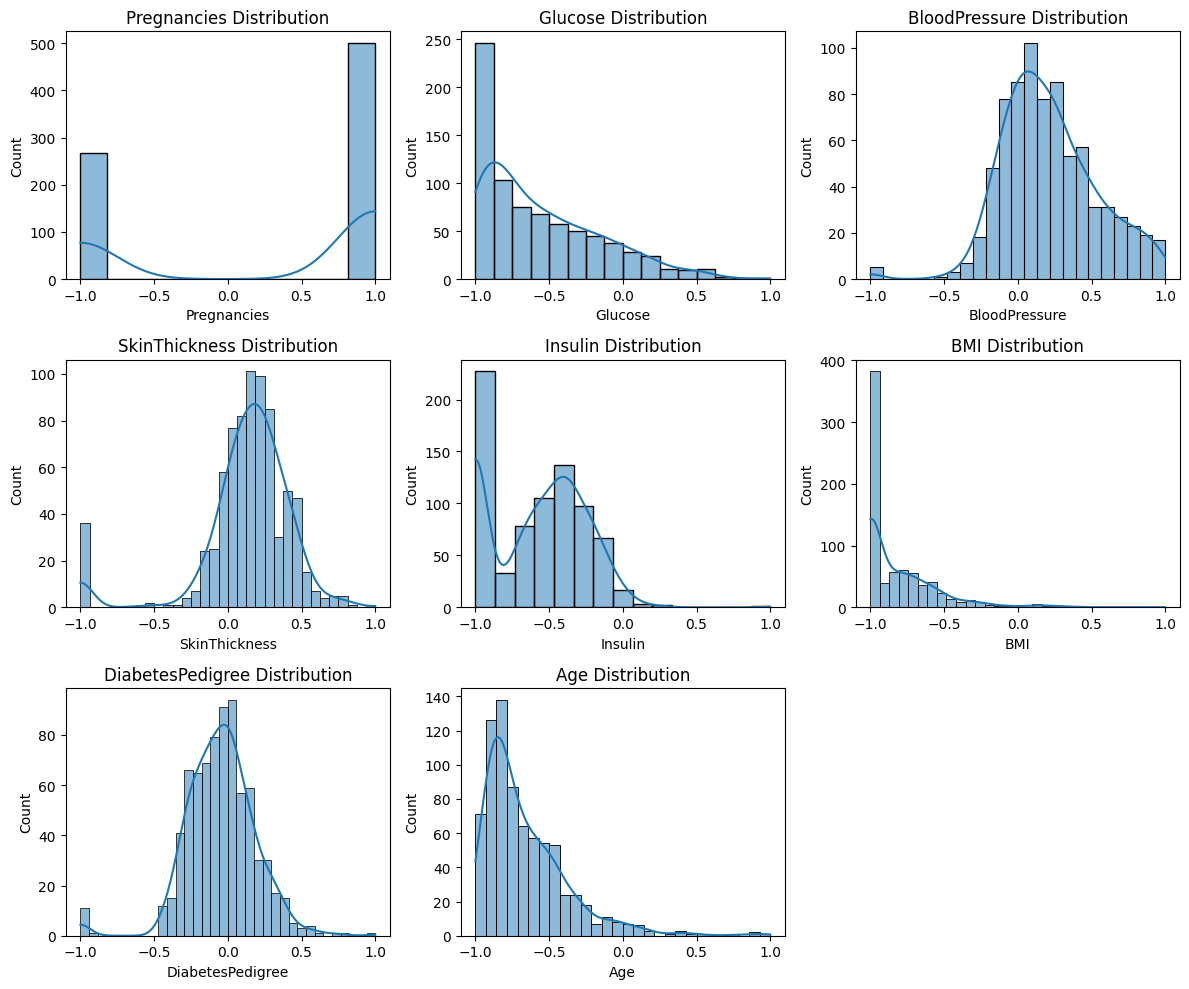

In [108]:

# visualizing the data

# Adding column names for clarity
column_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI',
                'DiabetesPedigree', 'Age', 'Outcome']
data.columns = column_names

# Createing a 3x3 grid for distribution plots
fig, axes = plt.subplots(3, 3, figsize=(12, 10))  # Create 3x3 grid
axes = axes.flatten()  # Flatten to easily iterate through subplots

# Plot each feature's distribution in the grid
for i, col in enumerate(column_names[:-1]): 
    sns.histplot(data[col], kde=True, ax=axes[i])  # Plot histogram with KDE
    axes[i].set_title(f'{col} Distribution')

# Remove the empty subplot (if there are fewer than 9 features)
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()


**Step 2**: Data Splitting into Features and Labels

In [125]:

# Load the dataset from CSV file
#data = pd.read_csv('diabetes_scale.csv', header=None)


# Separate features (x) and labels(y)
X = data.iloc[:, 1:].values  # All columns except the first are features
y = data.iloc[:, 0].values  # The first column is the label

# Normalize the features using StandardScaler
# StandardScaler standardizes features by removing the mean and scaling to unit variance

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  #Normalized the feature data

#  Convert the normalized features and labels to PyTorch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)  # contains the normalized feature values as a float32 tensor
y_tensor = torch.tensor((y + 1) / 2, dtype=torch.float32).reshape(-1, 1)  # contains the labels converted from [-1, 1] to [0, 1]

# Print the shape of the feature and label tensors to confirm successful transformation
print(f'Shape of X (features): {X_tensor.shape}')
print(f'Shape of y (labels): {y_tensor.shape}')



Shape of X (features): torch.Size([768, 8])
Shape of y (labels): torch.Size([768, 1])


In [126]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# X_scaled = scaler.fit_transform(X)

# #  Convert the normalized features and labels to PyTorch tensors
# X_tensor = torch.tensor(X_scaled, dtype=torch.float32)  # contains the normalized feature values as a float32 tensor
# y_tensor = torch.tensor((y + 1) / 2, dtype=torch.float32).reshape(-1, 1)  # contains the labels converted from [-1, 1] to [0, 1]

# # Print the shape of the feature and label tensors to confirm successful transformation
# print(f'Shape of X (features): {X_tensor.shape}')
# print(f'Shape of y (labels): {y_tensor.shape}')


**Step3:** Splitting Data into Training and Validation Sets

In [127]:
from sklearn.model_selection import train_test_split

# Split the dataset into training  and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Print the shape of the training and validation
# verify  the split was successful and the data dimensions are correct
print(f'Shape of X_train: {X_train.shape}, Shape of y_train: {y_train.shape}')
print(f'Shape of X_val: {X_val.shape}, Shape of y_val: {y_val.shape}')


Shape of X_train: torch.Size([614, 8]), Shape of y_train: torch.Size([614, 1])
Shape of X_val: torch.Size([154, 8]), Shape of y_val: torch.Size([154, 1])


Step:4 Check Class Distribution

In [128]:

#Calculate and display the distribution of classes (0 and 1) in the dataset
# torch.unique returns unique labels
labels, counts = torch.unique(y_tensor, return_counts=True)
print(f'Class Distribution: {dict(zip(labels.tolist(), counts.tolist()))}')


Class Distribution: {0.0: 268, 1.0: 500}


Step5: Calculating Weight Class

In [129]:
# Calculate class weights
# total_samples is the total number of samples in the dataset
total_samples = len(y_tensor)
# Calculate class weights: the total number of samples divided by the number of instances in each class
class_weights = [total_samples / count for count in counts]
# Converting the class weights into a PyTorch tensor
class_weights = torch.tensor(class_weights, dtype=torch.float32)
print(f'Class weights: {class_weights}')# Print the calculated class weights


Class weights: tensor([2.8657, 1.5360])


Step 6: Defineing and Instantiate Preceptron Model

In [130]:
import torch.nn as nn
import torch.optim as optim

# Define the Perceptron model
class Perceptron(nn.Module):
    def __init__(self, n_features):
        super(Perceptron, self).__init__()
        self.linear = nn.Linear(n_features, 1)  # Single-layer Perceptron with n_features inputs and 1 output

    def forward(self, x):
        return torch.sigmoid(self.linear(x))  # Apply the sigmoid function  for binary classification


# Instantiate the Perceptron model
n_features = X_tensor.shape[1]  # Number of features in the dataset
model = Perceptron(n_features)

# Define the loss function and optimizer
# Binary Cross-Entropy Loss is suitable for binary classification problems
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.SGD(model.parameters(), lr=0.01)  # Stochastic Gradient Descent with a learning rate of 0.01


Step 7: Transform Labels for Binary Cross-Entropy

In [131]:
# Transform labels from [-1, 1] to [0, 1] (because BCE expects 0/1 labels)

# Binary Cross-Entropy Loss expects labels to be either 0 or 1.
# the original labels are in the range [-1, 1], we transform them to [0, 1].
# applying the transformation (y + 1) / 2, which convert -1 to 0 and 1 to 1.
y_tensor = torch.tensor((y + 1) / 2, dtype=torch.float32).reshape(-1, 1)



Step8: Checking Tensor Shapes and varifying the datas

In [132]:
# Print the shape of the feature and label tensors to ensure they are correctly formatted for training
print(f'Shape of X (features): {X_tensor.shape}')  # (num_samples, num_features)
print(f'Shape of y (labels): {y_tensor.shape}')    # (num_samples, 1)


Shape of X (features): torch.Size([768, 8])
Shape of y (labels): torch.Size([768, 1])


In [133]:
# Print the first 5 rows of features and labels to inspect the data structure
print('The First 5 rows of features:')
print(X_tensor[:5])


# Print the first 5 rows of the label tensor to verify the label transformation
print('First 5 labels:')
print(y_tensor[:5])


The First 5 rows of features:
tensor([[ 6.3995e-01,  8.4832e-01,  1.5250e-01,  9.0727e-01, -6.9483e-01,
          2.0588e-01,  4.6147e-01,  1.4568e+00],
        [-8.4488e-01, -1.1234e+00, -1.5517e-01,  5.3090e-01, -6.9483e-01,
         -6.7490e-01, -3.6832e-01, -1.7380e-01],
        [ 1.2339e+00,  1.9437e+00, -2.5773e-01, -1.2882e+00, -6.9483e-01,
         -1.0901e+00,  5.9676e-01, -8.7971e-02],
        [-8.4488e-01, -9.9821e-01, -1.5517e-01,  1.5453e-01,  1.1959e-01,
         -4.8616e-01, -9.2151e-01, -1.0320e+00],
        [-1.1419e+00,  5.0405e-01, -1.4884e+00,  9.0727e-01,  7.6073e-01,
          1.4012e+00,  5.4552e+00, -2.1483e-03]])
First 5 labels:
tensor([[0.],
        [1.],
        [0.],
        [1.],
        [0.]])


Step 9: Checking and removing NaN Values in Features and Labels and replacing it

In [134]:
#Checking for NaN Values in Features and Labels

print(f'Any NaNs in features: {torch.isnan(X_tensor).any()}')
print(f'Any NaNs in labels: {torch.isnan(y_tensor).any()}')


Any NaNs in features: True
Any NaNs in labels: False


In [135]:
# Remove rows with NaN
# Create a mask to filter out rows where any feature contains NaN values

mask = ~torch.isnan(X_tensor).any(dim=1)

# Apply the mask to both the feature and label tensors
X_tensor = X_tensor[mask]  # Keep only rows without NaNs
y_tensor = y_tensor[mask]  # Ensure labels match the filtered features


In [136]:
# Replace NaN values with the mean of each feature
nan_mask = torch.isnan(X_tensor)

# Compute mean of each feature ignoring NaNs
mean_values = torch.nanmean(X_tensor, dim=0)
X_tensor[nan_mask] = torch.take(mean_values, nan_mask.nonzero()[:, 1])  # Replace NaNs with the corresponding feature's mean


In [137]:
# OR Replace NaNs with zeros
# Missing values are replaced with zeros
X_tensor = torch.nan_to_num(X_tensor, nan=0.0)


In [138]:
# Pass the feature tensor through the model to get the predicted outputs
output = model(X_tensor)
# This gives insight into the range of predictions which should ideally be between 0 and 1
print(f'Model outputs: min output = {output.min().item()}, max output= {output.max().item()}')

#loss = criterion(outputs, y_tensor)


Model outputs: min output = 0.09190010279417038, max output= 0.8641434907913208


Step 10:Check for NaNs in Features After Handling

In [139]:
print(f'Any NaNs in features after handling: {torch.isnan(X_tensor).any()}') #Checking for any NaN Value


Any NaNs in features after handling: False


Step 11: Define the Model, Loss Function, and Optimizer

In [143]:
# Define the model, loss function, and optimizer

# Initializing the Perceptron model with the number of features in the dataset
model = Perceptron(n_features=X_tensor.shape[1])

# Defining the loss function Binary Cross-Entropy Loss
criterion = nn.BCELoss()

# Define the optimizer with a learning rate of 0.01
optimizer = optim.SGD(model.parameters(), lr=0.01)  # Stochastic Gradient Descent optimizer

# Training
# n_iters sets the number of training iterations
n_iters = 1000  # (epochs)
loss_values = []        # Initialize list for storing loss values
accuracy_values = []    # Initialize list for storing accuracy values

for epoch in range(n_iters):
    # forward pass: Make  predictions on validation data
    outputs = model(X_tensor)  # Predicteed probabilities from the model. Outputs should be in [0, 1] range

    # Compute the loss between predictions and true labels
    loss = criterion(outputs, y_tensor)

    # Backward pass: Calculate gradients and optimization
    optimizer.zero_grad()  # Clear the gradients from the previous step
    loss.backward()  # Backpropagate the loss
    optimizer.step()  # Update model parameters (i.e. weights)

    # Store loss and accuracy for plotting
    loss_values.append(loss.item())
    # Convert predicted probabilities to binary labels (0 or 1) using a threshold of 0.5
    predictions = (outputs >= 0.5).float()
    accuracy = torch.mean((predictions == y_tensor).float()).item()
    accuracy_values.append(accuracy)

    # Print progress every 100 epochs to monitor progress
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{n_iters}], Loss: {loss.item():.4f}')


Epoch [100/1000], Loss: 0.6178
Epoch [200/1000], Loss: 0.5665
Epoch [300/1000], Loss: 0.5371
Epoch [400/1000], Loss: 0.5188
Epoch [500/1000], Loss: 0.5067
Epoch [600/1000], Loss: 0.4982
Epoch [700/1000], Loss: 0.4922
Epoch [800/1000], Loss: 0.4877
Epoch [900/1000], Loss: 0.4844
Epoch [1000/1000], Loss: 0.4818


Step 12: Defining and making predictions and calculating accuracy


In [144]:
# Predict function: Convert outputs to binary class (0 or 1) using a 0.5 threshold
def predict(model, X):
    outputs = model(X)# Get model outputs
    predictions = (outputs >= 0.5).float()  # Apply threshold of 0.5 to get binary predictions in [0, 1]range
    return predictions

# Make predictions on the training data
y_pred = predict(model, X_tensor)# Using the predict function to make predictions on the training data

# Compute accuracy
accuracy = torch.mean((y_pred == y_tensor).float()) # calculateing mean accuracy as the proportion of correct predictions
print(f'Accuracy: {accuracy.item() * 100:.2f}%') # Print the accuracy as a percentage



Accuracy: 77.73%


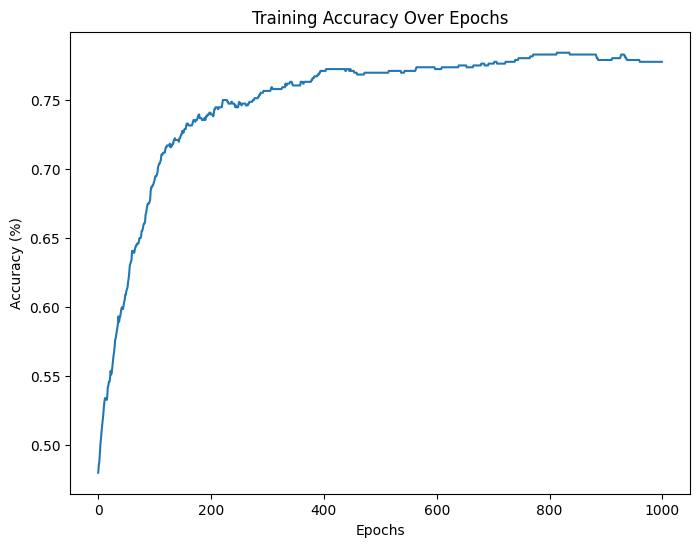

In [145]:
#  Plot Accuracy vs. Epochs
import torch.nn as nn
import torch.optim as optim
plt.figure(figsize=(8, 6))
plt.plot(range(n_iters), accuracy_values)
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.show()

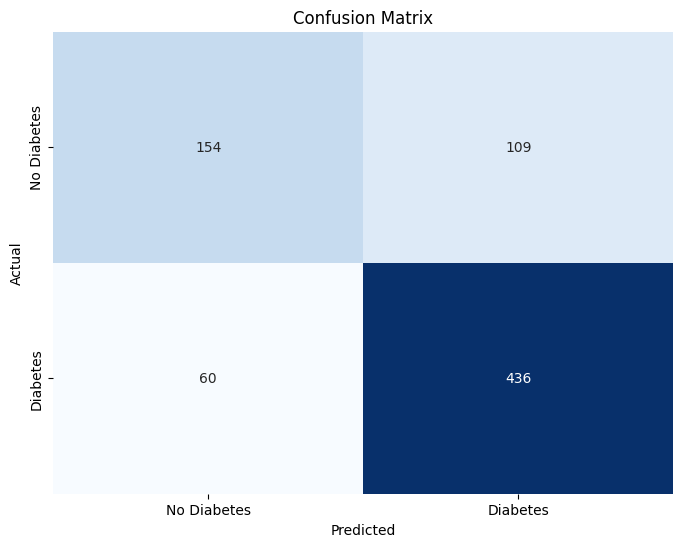

In [146]:


# Compute the confusion matrix
cm = confusion_matrix(y_tensor, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No Diabetes", "Diabetes"], yticklabels=["No Diabetes", "Diabetes"])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

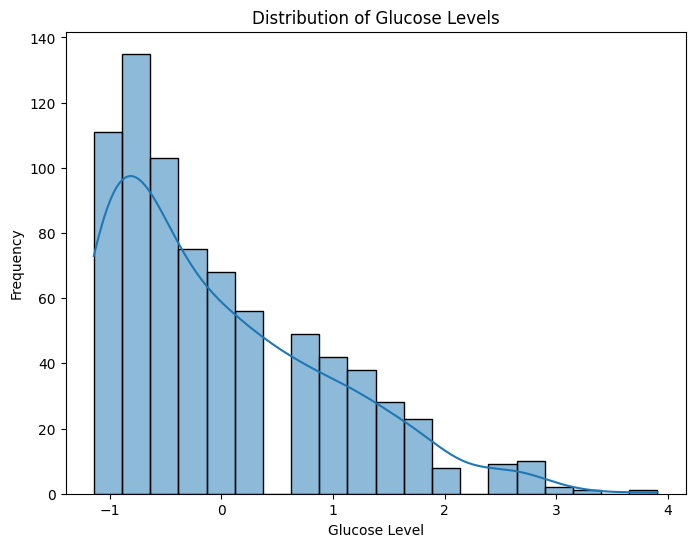

In [147]:
import matplotlib.pyplot as plt
import seaborn as sns
# Assuming that glucose level is first feature (index 0)
glucose_levels = X_tensor[:, 0].numpy()  # Extracting the glucose levels from the feature tensor

# Plotting distribution of glucose levels
plt.figure(figsize=(8, 6))
sns.histplot(glucose_levels, bins=20, kde=True)
plt.title('Distribution of Glucose Levels')
plt.xlabel('Glucose Level')
plt.ylabel('Frequency')
plt.show()